# Netosis dataset analysis
In this notebook, we setup a workflow for processing the "Netosis" dataset. This includes
* deskewing using [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) (version 0.14.0),
* deconvolution using [RegLionFish](https://github.com/rosalindfranklininstitute/RedLionfish/) (version 0.6),
* object segmentation + classification using [apoc](https://github.com/haesleinhuepf/apoc) (version 0.6.3).

In [1]:
import dask
import dask.array as da
from pyclesperanto_prototype import imshow

import pyclesperanto_prototype as cle
import RedLionfishDeconv as rl
import apoc

from aicsimageio import AICSImage
from functools import partial
import numpy as np
from skimage.io import imread, imsave


In [2]:
voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3
deskewing_angle_in_degrees = 30

We start with loading the image data and the point-spread-function (PSF) image.

In [3]:
data_path = 'C:/structure/data/netosis_deskew/Netosis_large_stack2-timelaps.tif'
data = imread(data_path)

In [4]:
# We extract a timepoint for now
timepoint = 15

raw_image = data[timepoint] #.dask_data[0,0,:400,:,:500]
raw_image.shape

(834, 291, 851)

In [5]:
# print image size in megabytes
np.prod(raw_image.shape) / 1024 / 1024

196.96483039855957

In [6]:
# The result image may be too large for my GPU memory. Hence, we set a scale_factor
scale_factor = 0.5

In [7]:
data_psf_path = '../sample_data/30x1000 _3color_deskew.czi'
channel = 1

psf_image = AICSImage(data_psf_path).dask_data[0, channel]
psf_image

dask.array<getitem, shape=(200, 42, 55), dtype=uint16, chunksize=(200, 42, 55), chunktype=numpy.ndarray>

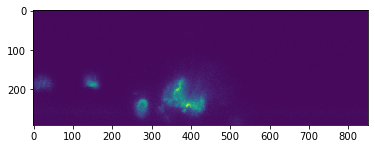

In [8]:
cle.imshow(raw_image[100])

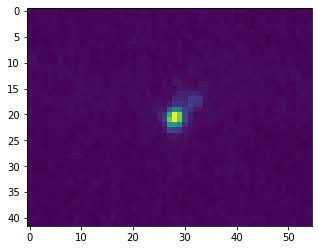

In [9]:
cle.imshow(psf_image[100])

## Deskewing
We deskew the dataset using [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype/) as shown in [this notebook](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/transforms/deskew.ipynb).

In [10]:
deskewed_image = cle.deskew_y(raw_image, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns,
                        scale_factor=scale_factor)

deskewed_image.shape

(72, 993, 425)

In [11]:
psf_image.shape

(200, 42, 55)

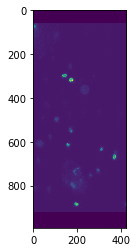

In [12]:
cle.imshow(deskewed_image[40])

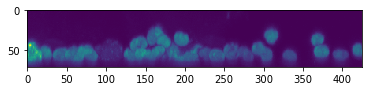

In [13]:
cle.imshow(cle.maximum_y_projection(deskewed_image))

## Dconvolution
We will use [RedLionFish](https://github.com/rosalindfranklininstitute/RedLionfish) 
to apply [Richardson-Lucy-Deconvolution](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution) as shown in 
[this notebook](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/18a_deconvolution/richardson_lucy_deconvolution.html). 

It should be considered to do the deconvolution before the deskewing. However, Robert _thinks_ that the given PSF was deskewed.

In [14]:
iterations = 10

deconvolved_image = rl.doRLDeconvolutionFromNpArrays(deskewed_image, 
                                               psf_image, 
                                               niter=iterations, 
                                               method='gpu', 
                                               resAsUint8=False )

if deconvolved_image is None:
    # Deconvolution doesn't work on some datasets (not sure why)
    #                                                  Robert
    print("Error: deconvolved image was None! Will continue with the passed image")
    deconvolved_image = deskewed_image
deconvolved_image.shape

(72, 993, 426)

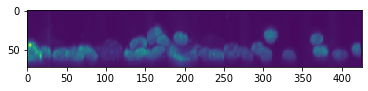

In [15]:
cle.imshow(cle.maximum_y_projection(deconvolved_image))

In [16]:
# I was saving the data here to load it in napari and train an object-segmenter (APOC)
#imsave("deconvolved.tif", deconvolved_image)

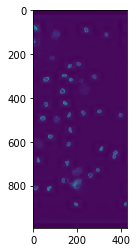

In [17]:
cle.imshow(deconvolved_image)

## Object segmentation
Object segmentation in APOC works using a Random Forest Classifier + Connected Component Labeling of one specific class of the resulting semantic segmentation. All is done in a single step.

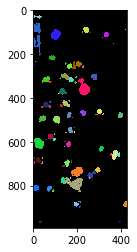

In [18]:
object_segmenter = apoc.ObjectSegmenter(opencl_filename="Netosis_ObjectSegmenter.cl")

label_image = object_segmenter.predict(deconvolved_image)

cle.imshow(label_image, labels=True)

## Object classification
Object classification in APOC is done by extracting features and then applying a Random Forest Classifier to classify the objects according to these features. The classifier is a human readable text file, we can have a look into to see the configuration of the classifier.

In [19]:
N = 11
with open("Netosis_ObjectClassifier.cl") as myfile:
    head = [next(myfile) for x in range(N)]
print("\n".join(head))

/*

OpenCL RandomForestClassifier

classifier_class_name = ObjectClassifier

feature_specification = area mean_intensity standard_deviation_intensity mean_max_distance_to_centroid_ratio

num_ground_truth_dimensions = 1

num_classes = 3

num_features = 4

max_depth = 2

num_trees = 10

apoc_version = 0.6.1

*/



Hence, this classifier differentiates three classes according to:
* area
* mean intensity
* standard deviation intensity
* shape (mean_max_distance_to_centroid_ratio)

I annotated objects like this:
* Normal cells
* Exploded cells
* Tiny artifacts (presumably no cells)

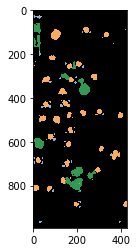

In [20]:
object_classifier = apoc.ObjectClassifier(opencl_filename="Netosis_ObjectClassifier.cl")

classification_image = object_classifier.predict(label_image, deconvolved_image)

cle.imshow(classification_image, labels=True)

## Applying the whole workflow to a different time point|

In [21]:
def deskewing_deconvolution_segmentation_classification(data, psf_image, timepoint, scale_factor):
    raw_image = data[timepoint]

    # deskewing
    print("Deskewing...")
    deskewed_image = cle.deskew_y(raw_image, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns,
                        scale_factor=scale_factor)

    # deconvolution
    print("Deconvolution...")
    iterations = 10
    deconvolved_image = rl.doRLDeconvolutionFromNpArrays(deskewed_image, 
                                               psf_image, 
                                               niter=iterations, 
                                               method='gpu', 
                                               resAsUint8=False )
    
    # segmentation
    print("Segmentation...")
    object_segmenter = apoc.ObjectSegmenter(opencl_filename="Netosis_ObjectSegmenter.cl")
    label_image = object_segmenter.predict(deconvolved_image)
    
    # classification
    print("Classification...")
    object_classifier = apoc.ObjectClassifier(opencl_filename="Netosis_ObjectClassifier.cl")
    classification_image = object_classifier.predict(label_image, deconvolved_image)
    
    return raw_image, deskewed_image, deconvolved_image, label_image, classification_image

timepoint = 10
raw_image, deskewed_image, deconvolved_image, label_image, classification_image = deskewing_deconvolution_segmentation_classification(data, psf_image, timepoint, scale_factor)

Deskewing...
Deconvolution...
Segmentation...
Classification...


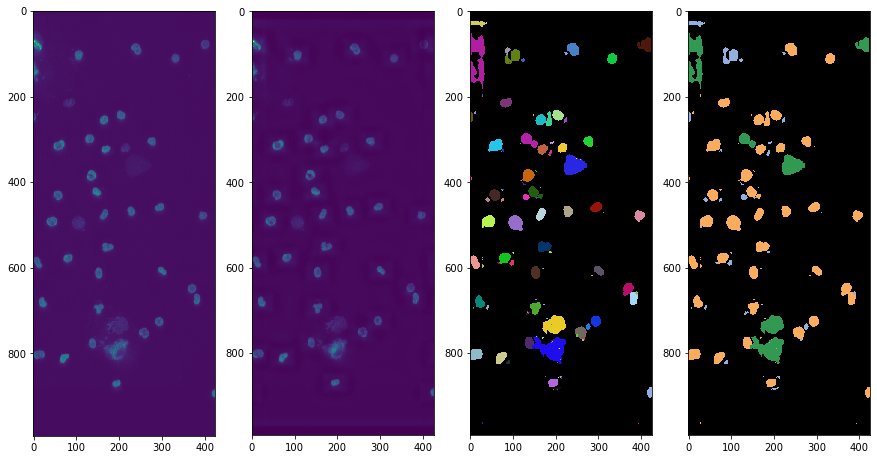

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15,15))

cle.imshow(deskewed_image, plot=axs[0])
cle.imshow(deconvolved_image, plot=axs[1])
cle.imshow(label_image, plot=axs[2], labels=True)
cle.imshow(classification_image, plot=axs[3], labels=True)

## Applying the workflow to a selection of time points

Timepoint 0
Deskewing...
Deconvolution...
Segmentation...
Classification...


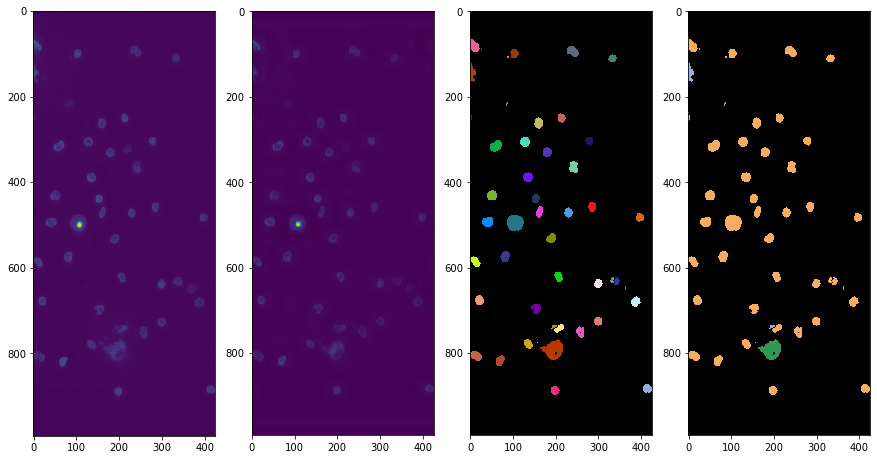

Timepoint 4
Deskewing...
Deconvolution...
Segmentation...
Classification...


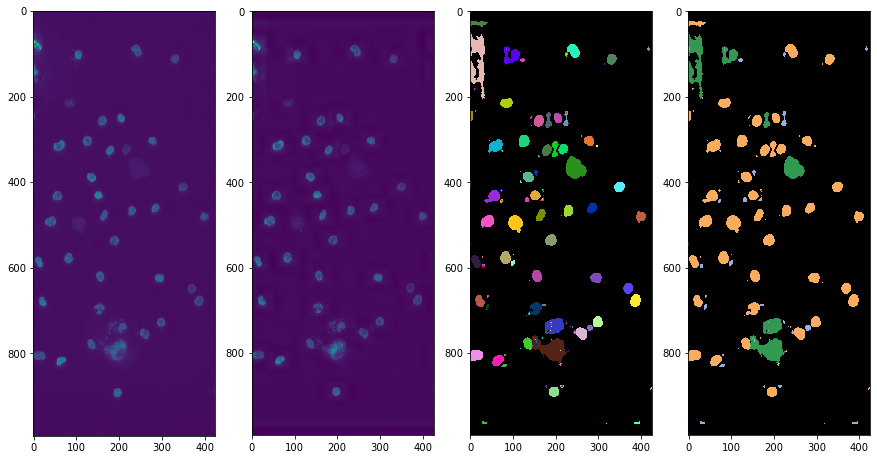

Timepoint 8
Deskewing...
Deconvolution...
Segmentation...
Classification...


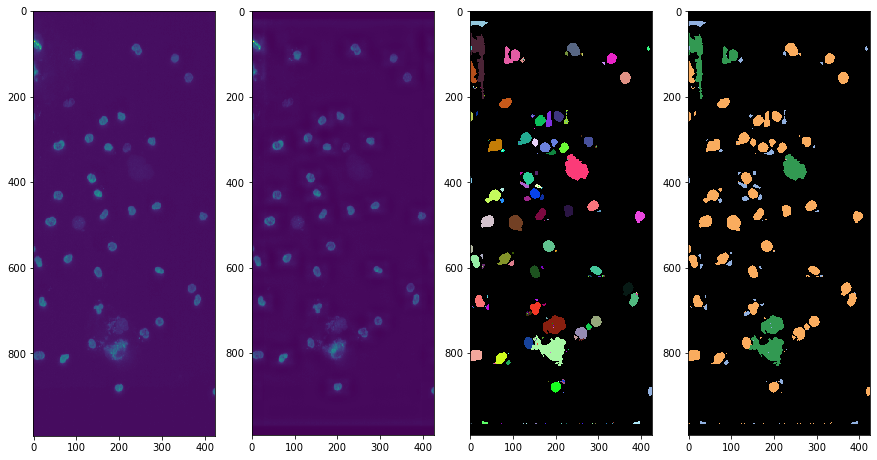

Timepoint 12
Deskewing...
Deconvolution...
Segmentation...
Classification...


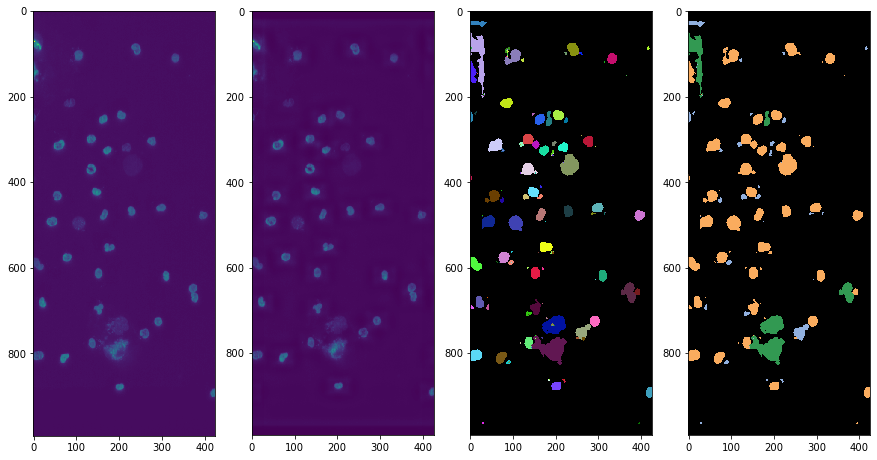

Timepoint 16
Deskewing...
Deconvolution...
Segmentation...
Classification...


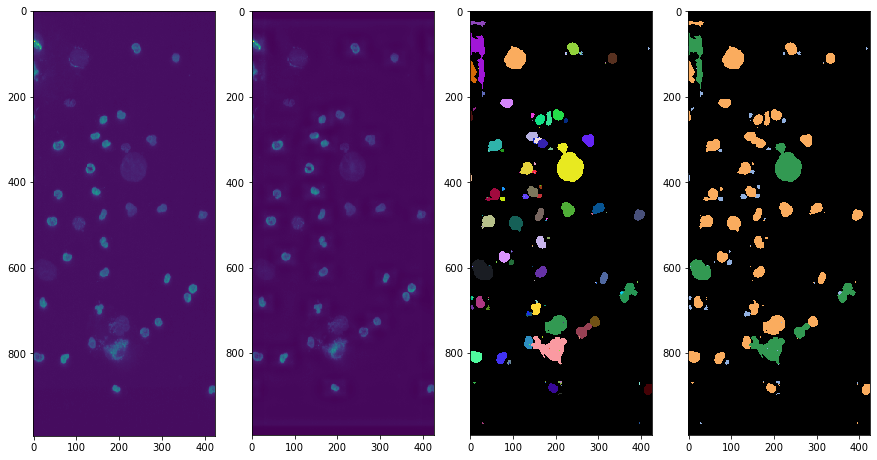

Timepoint 20
Deskewing...
Deconvolution...
Segmentation...
Classification...


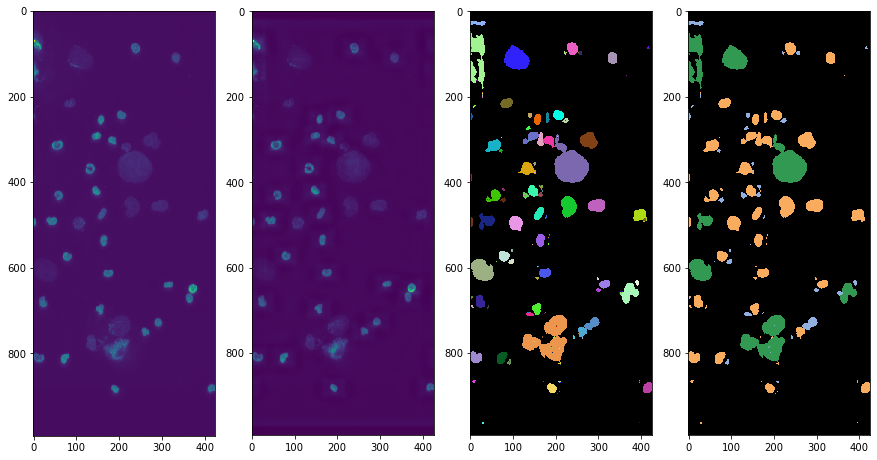

In [23]:
for timepoint in range (0, 21, 4):
    print("Timepoint", timepoint)
    raw_image, deskewed_image, deconvolved_image, label_image, classification_image = deskewing_deconvolution_segmentation_classification(data, psf_image, timepoint, scale_factor)

    fig, axs = plt.subplots(1, 4, figsize=(15,15))

    cle.imshow(deskewed_image, plot=axs[0])
    cle.imshow(deconvolved_image, plot=axs[1])
    cle.imshow(label_image, plot=axs[2], labels=True)
    cle.imshow(classification_image, plot=axs[3], labels=True)
    plt.show()